



## Classifying Characters with Disabilities in Fiction from the Words Associated with Them: A Pilot Project
Ryan Dubnicek (May 11, 2017)

### Introduction & Project Summary
This project seeks to build a classifier in Python, using naïve Bayes, to pilot identification of characters with disabilities in fiction. I use data resulting from David Bamman and Ted Underwood’s work with HathiTrust fiction data using Bamman’s Book NLP  pipeline. I identified 54 characters from just over 30 volumes that had disabilities of some kind—for this project, disabilities are defined as both physical and mental, as well as conditions that are found in the Diagnostic and Statistical Manual of Mental Disorders, Fifth Edition (DSM-5). This is certainly not a perfect definition, but it’s one to use to ground my classifications, and one that is wide enough to not prohibit this type of study at all due to lack of training data.

In the end, I was able to us naïve Bayes to train a classifier that reliably picked out characters with disabilities amongst the ~120 characters chosen for study, with a 92% average accuracy. After completing the classifier, and without the compute resources to extend it run against characters for all  ~94,000 volumes of fiction against which Book NLP was run to extract data, I decided to take a deeper look into the words associated with each class of characters. I used TextBlob  to run sentiment analysis and objectivity of said analysis, against words for each character, and also used some homegrown functions that leverage Dunnings log likelihood to pull the most overrepresented and underrepresented words for each class of character. All together, this data affirmed some assumptions that many in disability studies would’ve made prior to this project: fewer action words were in the top words associated with characters with disabilities and average sentiment is 2.5 times lower than the words that are associated with characters without. However, objectivity of sentiment for words associated with characters with disabilities was lower, which was a surprise, given the radically different average sentiment, and the distribution of sentiment per character, with most characters sentiments below the neutral line, as compared to a normal distribution.

### Preface
This notebook is a companion to a short write-up, available for download [here](https://github.com/rdubnic2/lis590dsh/blob/master/LIS%20590DSH%20Final%20Project/final-submitted/Dubnicek_LIS590DSH-Final-Project_write-up.docx), that makes up my final project for LID 590DSH, Data Science in the Humanities, taught by Professor Ted Underwood at the UIUC School of Information Sciences. This project uses characters and the words associated with them that were extracted from fiction in [HathiTrust (HT)](https://www.hathitrust.org). I employ a number of functions developed over the course of the class, most authored by or seeded by Dr. Underwood, and modified--to varying levels--by me. I don't purport necessarily that they are the best version of their methods, for instance, I employ a homegrown naive Bayes classifier rather than use TextBlob's or Scikit-learn's versions. However, each is understandable to me, a relative text mining novice, and shamefully, but truthfully fierce statistics novice. Naive Bayes may not be the best classifier in this instance either, but it is a classifier I understand and have experience with. Should this project ever grow from this relative pilot project, a look into which classifier might best suit my needs is a must.

If you have any questions, please feel free to drop me a note at rdubnicek@gmail.com

### Data Collection and Cleaning
As my write-up mentions, I worked off of character data that Ted Underwood and David Bamman, using Bamman's [Book NLP](https://github.com/dbamman/book-nlp), a natural language processing (NLP) pipeline that scales specifically for books and other long texts, extracted from fiction in HT. However, prior to actually accessing this data, I needed to identify a subset of volumes that had characters with disabilities, and then record the names of those characters specifically, for later manual classification for training my predictive model. This was an extremely long and tedious process, and highlighted the complete lack of any comprehensive information on characters in fiction with disabilities, as I was often resigned to manually surfing top 10 lists from blogs or user-compiled lists on Goodreads.

This is probably the best place to speak a bit about the definition of "disability" I am using for this project. I am including both physical and mental disabilities, with the former relatively straightforward, and taking the shape of paralysis, lost limbs, disfigurement and blindness/deafness. The latter is far more nebulous, and difficult to pin down, not just for me but for scholars in disability studies, even. In the end, I decided to use the DSM-5 as a guiding framework for mental disability inclusion, both because I was hoping to see how the classifier might react with such a wide definition and because I didn't want to limit my data to an unusable small amount of characters with disabilities. So, mental disabilities, in this project, can be Downs Syndrome, Autism spectrum disorders and other intellectual disabilities, or things like unnamed mental illness, schizophrenia, PTSD and bi-polar disorder. While I’ve had some training in disability studies and special education, I am not an expert, and generally erred on the side of the most inclusive definition for this project.

Once volumes and characters were identified, the corresponding character data for all characters in the book, was extracted into JSON, and parsed by Dr. Underwood using a Python notebook. My entry into the data came after characters for my small corpus were gathered from the overall character data and sent to me in .csv form. At this point, the data, when loaded into a dataframe, looked like this:

In [1]:
# some imports we'll be using in this notebook

import csv, os, math, random
import pandas as pd
import numpy as np
from collections import Counter
from textblob import TextBlob
import random
import matplotlib
import seaborn
%matplotlib inline

In [2]:
raw_data = open('allchars.csv', 'r')
raw_df = pd.read_csv(raw_data)
raw_df.head()

,Unnamed: 0,bookid,name,words
0,0,10117,Theodore,remember
1,1,10117,Mademoiselle,repeat pour
2,2,10117,Mr. Rochester,take commissioned intends does was lay carried...
3,3,10117,Mr. Broeklehurst,said
4,4,10117,Miss Temple,received name face side ear eye bed


This is a great start, but I needed to massage this a bit, and add a few columns for later programmatic analysis and for my own manual work. I added a column that would be used in classification, `'has_disability'`, but, after trying out a few methods and running into trouble, as well as having a few incidents of losing data I had enriched, I just decidedly to manually update the .csv in Excel versus writing loops to find the characters with disabilities that I had hand identified and change their value in that column. I also added a column, `'bookname'`, which helped me more easily get the character names for each volume, and make sure I had the correct representation of each character based on the Book NLP data. My data ended up looking like this:

In [3]:
ch_data = open('allchars_RD.csv', 'r')
ch_df = pd.read_csv(ch_data)
# ch_df.head()

del ch_df['Unnamed: 0']
ch_df['bookname'] = ''

ch_df.head()

,bookid,name,has_disability,words,bookname
0,6479,Mathias,0,shook surrounded grumbled legs knowledge head,
1,6479,Pasquier,0,best,
2,6479,Du Breul,0,blocked,
3,6479,Guillaume Eym,0,considered intervene,
4,6479,Tourangeau,0,took replied cap,


In order to then accurately populate the `'bookname'` column, I wrote an excessively lengthy for loop to do this in one go, as compared to changing out text, or using lists to iterate over:

In [4]:
# this long loop will trigger multiple warnings that don't matter much for us here, so we disable the warnings
#  prior to running the loop. The loop still takes a while to execute, though.
pd.options.mode.chained_assignment = None

for i in ch_df.index:
        bookid = ch_df['bookid'][i]
        if bookid == '6479':
            ch_df['bookname'][i] = 'Notre Dame de Paris'
        elif bookid == '8469':
            ch_df['bookname'][i] = 'Wuthering Heights'
        elif bookid == 'mdp.39015000608102':
            ch_df['bookname'][i] = 'Winesburg, Ohio'
        elif bookid == 'mdp.39015002311556':
            ch_df['bookname'][i] = 'The Secret Garden'
        elif bookid == 'uc2.ark+=13960=t22b8w678':
            ch_df['bookname'][i] = 'The Crux'
        elif bookid == 'inu.30000003130071':
            ch_df['bookname'][i] = "Lady Chatterley's Lover"
        elif bookid == 'mdp.39015002153180':
            ch_df['bookname'][i] = 'A Good Man is Hard to Find'
        elif bookid == 'mdp.39015002260167':
            ch_df['bookname'][i] = 'Of Mice and Men'
        elif bookid == 'mdp.39015008102165':
            ch_df['bookname'][i] = 'In This Sign'
        elif bookid == 'mdp.39015008821251':
            ch_df['bookname'][i] = 'The Illearth War'
        elif bookid == 'mdp.39015043002289':
            ch_df['bookname'][i] = 'Johnny Got His Gun'
        elif bookid == 'pst.000022105387':
            ch_df['bookname'][i] = 'The Wounded Land'
        elif bookid == 'uc1.b4439246':
            ch_df['bookname'][i] = 'The One Tree'
        elif bookid == 'mdp.39015040597794':
            ch_df['bookname'][i] = 'Flowers for Algernon'
        elif bookid == 'mdp.39015062063501':
            ch_df['bookname'][i] = 'The Curious Incident of the Dog in the Night-Time'
        elif bookid == 'mdp.39015054102655':
            ch_df['bookname'][i] = 'The English Patient'
        elif bookid == 'uc1.32106011264659':
            ch_df['bookname'][i] = 'Cathedral'
        elif bookid == 'pst.000044192167':
            ch_df['bookname'][i] = 'The Heart is a Lonely Hunter'
        elif bookid == 'mdp.39015054067759':
            ch_df['bookname'][i] = 'The Things They Carried'
        elif bookid == 'mdp.39015046349141':
            ch_df['bookname'][i] = 'The Sound and the Fury'
        elif bookid == 'mdp.39015040081708':
            ch_df['bookname'][i] = 'Geek Love'
        elif bookid == 'pst.000018729719':
            ch_df['bookname'][i] = 'The Bell Jar'
        elif bookid == 'uc1.32106010927215':
            ch_df['bookname'][i] = "One Flew over the Cuckoo's Nest"
        elif bookid == 'uc1.b3462870':
            ch_df['bookname'][i] = 'Alice in Bed'
        elif bookid == 'mdp.39015028400326':
            ch_df['bookname'][i] = 'Jewel'
        elif bookid == 'mdp.39015063339868':
            ch_df['bookname'][i] = 'We Are All Welcome Here'
        elif bookid == 'uc1.32106002122734':
            ch_df['bookname'][i] = 'To Kill A Mockingbird'
        elif bookid == 'uc1.32106014098278':
            ch_df['bookname'][i] = "The Optimist's Daughter"
        elif bookid == 'uc1.$b322793':
            ch_df['bookname'][i] = 'The Last September'
        elif bookid == 'uc1.$b784307':
            ch_df['bookname'][i] = 'Back'

ch_df.head()

,bookid,name,has_disability,words,bookname
0,6479,Mathias,0,shook surrounded grumbled legs knowledge head,Notre Dame de Paris
1,6479,Pasquier,0,best,Notre Dame de Paris
2,6479,Du Breul,0,blocked,Notre Dame de Paris
3,6479,Guillaume Eym,0,considered intervene,Notre Dame de Paris
4,6479,Tourangeau,0,took replied cap,Notre Dame de Paris


The inclusion of this column is optional, but it helped me spot check the characters that I knew should be assigned 1 values in their `'has_disability'` column, and also helped me get a better sense of the rough amount of characters per book.

After the data was in this form, I did a quick loop to get a sense of how many characters had disabilities versus how many did not, along with the words describing the characters with disabilities. This data was needed in my next step, which was to make sure we had nearly equal amounts of characters and words for each class, so as to not skew the classifier. Here are the loops:

In [5]:
dis_char_list = []
no_dis_char_list = []

for i in ch_df.index:
    name = ch_df['name'][i]
    dis = ch_df['has_disability'][i]
    if dis == 1:
        dis_char_list.append(name)
        # print(name)
    elif dis != 1:
        no_dis_char_list.append(name)
        # print(name)

print('There are', len(dis_char_list), 'characters with disabilities in this corpus.')
print('There are', len(no_dis_char_list), 'characters with disabilities in this corpus.')

dis_wrd_ct = 0
no_dis_wrd_ct = 0

for i in ch_df.index:
    text = str(ch_df['words'][i])
    blob = TextBlob(text)
    words = blob.words
    dis = ch_df['has_disability'][i]
    if dis == 0:
        no_dis_wrd_ct += len(words)
print('There are', no_dis_wrd_ct,'words associated with characters without disabilities')

for i in ch_df.index:
    text = str(ch_df['words'][i])
    blob = TextBlob(text)
    words = blob.words
    dis = ch_df['has_disability'][i]
    if dis == 1:
#         dis_words.append(words)
        dis_wrd_ct += len(words)
print('There are', dis_wrd_ct,'words associated with characters with disabilities')

There are 64 characters with disabilities in this corpus.
There are 1881 characters with disabilities in this corpus.
There are 90091 words associated with characters without disabilities
There are 14772 words associated with characters with disabilities


At this point, both our numbers of characters and words for each class are very far apart, which can negatively impact our classifier. To correct this, I wrote another loop to drop rows of the dataframe where the number of words was less than 150 and the row number was divisible by 2 (an arbitrary parameter) for characters without disabilities. I knew this wouldn't be the last step, but I was curious to see how this might affect the total words for each class of character. *Note: when I initially tried out this code, I made a copy of my dataframe to make sure things weren't irreparably damaged. I'd recommend that course of action first for anyone recreating this type of work.*

Here's the code:

In [6]:
for i in ch_df.index:
    dis = ch_df['has_disability'][i]
    words = str(ch_df['words'][i])
    if dis == 0 and len(words) < 150 and i%2 == 0:
        # print('found one')
        ch_df.drop(i, inplace=True)

# since we've dropped rows, we'll reset the index        
ch_df = ch_df.reset_index(drop=True)  

ch_df.shape

(1282, 5)

Notice, I first tested to see how many rows might be affected, by commenting out the drop line and using the print line to inform me a row meeting the conditions was found. This was a good failsafe for me throughout the data winnowing portion of this project.

We're down to 1282 total rows, which puts just at 1218 characters without disabilities, still far too many. At this point, I realized it would be most efficient to pull down the rows for all characters with disabilities and save it to a .csv using `pd.to_csv`. This would allow me to not worry about accidentally affecting those rows, which would necessarily affect any work to correctly limit rows and words for characters without disabilities. Once I had correctly culled my data frame for characters without disabilities, it'd be simple to concatenate that dataframe back with the one with data for characters with disabilities. That code mirrors what's above, just without any further conditions after `dis == 1`, which would drop all rows for characters without a disability. I then reloaded the `ch_df` dataframe and reproduced the above winnow steps and the immediately above winnowing to bring me back to where I was.

At this point, it became clear that the easier way to cut the number of rows was to simply take a random sample using a built in `.sample()` method, which can take a parameter `n` that stands for the number of rows you want returned:

In [7]:
no_dis_sample = ch_df.sample(n=65)
no_dis_sample = no_dis_sample.reset_index(drop=True)
# renaming the dataframe
no_dis_df = no_dis_sample
no_dis_df.head()

# saving my dataframe once I got the right number of words and rows, obviously not with a file name now to prevent any
#  accidents.
no_dis_sample.to_csv('INSERT ANY FILE NAME AND EXTENSION HERE')

### Training a Naive Bayes Classifier
In the end, I needed to tweak my rows in the no disability dataframe to be 65 in order to get closer to the amount of words in my disability data frame, which I had cut 10 of the least-popualted rows from as well to get the word coutns in sync. This step is hard, if not impossible, to reproduce, as I used the `.random` method, which is, well, random. Instead, I've including my final two data frame files, as .csv files, in this folder, and we can now load and concatenate them to come up with our final dataframe, and start our analysis:

In [8]:
dis_data = open('dis_df.csv', 'r')
no_dis_data = open('no_dis_sample_5819.csv', 'r')

dis_df = pd.read_csv(dis_data)
no_dis_df = pd.read_csv(no_dis_data)

# dis_df.head()
# no_dis_df.head()

df_list = [dis_df, no_dis_df]
char_df = pd.concat(df_list)
# it's vital to reset the index here, else we'll throw errors in our functions later due to duplicate indices
char_df = char_df.reset_index(drop=True)
# deleting our pesky nemesis, column 'Unnamed: 0', which keeps recurring when we ingest our charactr dataframes
del char_df['Unnamed: 0']
char_df.head()

,bookid,name,has_disability,words,bookname
0,8469,Linton,1,had stood whispered stood ate look does replie...,Wuthering Heights
1,inu.30000003130071,Clifford,1,went had came had drive pretended was was had ...,Lady Chatterley's Lover
2,mdp.39015000608102,Parcival,1,had appeared been told began began began know man,"Winesburg, Ohio"
3,mdp.39015000608102,Elizabeth,1,was went went went yearned cried clenched decl...,"Winesburg, Ohio"
4,mdp.39015000608102,Enoch,1,informed emerged lived walked came realise was...,"Winesburg, Ohio"


Later, we'll compare our classifier for identifying characters with disabilities to one that does the same, but to find the male and female characters. In order to enable this, we'll output a copy of our final character data frame to a .csv and add in genders based on names, where possible, and from a bit of old-fashioned Google searching where gender wasn't evident from:

In [9]:
# commenting out these line to prevent an overwrite of our enhanced dataframe with gender
# char_df['gender'] = ''
# char_df.head()
# char_df.to_csv('ch_gen.csv')

ch_gen_data = open('ch_gen.csv', 'r')
ch_gen = pd.read_csv(ch_gen_data)

del ch_gen['Unnamed: 0']

print(ch_gen.shape)

no_gen_list = ['El Camino College','New Willard House','Warward']    

for i in ch_gen.index:
    name = ch_gen['name'][i]
    if name in no_gen_list:
        print('found one')
        ch_gen.drop(i, inplace=True)

print(ch_gen.shape)

ch_gen.head()

(119, 6)
found one
found one
found one
(116, 6)


,bookid,name,has_disability,words,bookname,gender
0,8469,Linton,1,had stood whispered stood ate look does replie...,Wuthering Heights,1
1,inu.30000003130071,Clifford,1,went had came had drive pretended was was had ...,Lady Chatterley's Lover,1
2,mdp.39015000608102,Parcival,1,had appeared been told began began began know man,"Winesburg, Ohio",1
3,mdp.39015000608102,Elizabeth,1,was went went went yearned cried clenched decl...,"Winesburg, Ohio",0
4,mdp.39015000608102,Enoch,1,informed emerged lived walked came realise was...,"Winesburg, Ohio",1


As you can see, there's also a quirk with our character data, and three entities that aren't traditionally considered characters have been included in our dataframe. Though these won't skew our disability test, they will make it impossible to assign a gender value for those rows, so I've dropped them.

Now we need to streamline and adjust our disability dataframe for use as a training and test set. This involves a few small steps, including removing all columns save for `'has_disability'` and `'words'`:

We're now ready to randomly assign folds so that we can have a training set and a test set, and append the fold numbers to a new column which will be used to call each subset. To do this, we need a very simple test to return if the row is for a character with a disability or not. This function will also help us replace our binary column with `'y'` or `'n'` in place of 0 or 1, which occasionally caused trouble due to their status as integers:

In [10]:
def dis_test(a_data_frame, rowidx):
    if a_data_frame['has_disability'][rowidx] == 1: # checking our binary column for identification of each review
        return 'y'
    else:
        return 'n'

Now, here is the code for creating a new dataframe, `char_basic`, with fold and source columns added:

In [11]:
labels = char_df['has_disability']
words = char_df['words']

source = []
fold = []

for idx in char_df.index: # iterating through a data frame, by row, based on index
    source.append(dis_test(char_df, idx)) # using the dis_test function above to populate the source column
    fold.append(random.sample(list(range(5)), 1)[0]) # using random.sample to populate the source column

source = pd.Series(source, index = char_df.index) # creating a Pandas series out of the above source info
fold = pd.Series(fold, index = char_df.index) # creating a Pandas series out of the above fold info

char_basic = pd.concat([words, source, fold], axis = 1) # creating a new data frame with all of the above info
char_basic.columns = ['words', 'has_disability', 'fold'] # renaming columns for our use

char_basic.head()

,words,has_disability,fold
0,had stood whispered stood ate look does replie...,y,3
1,went had came had drive pretended was was had ...,y,3
2,had appeared been told began began began know man,y,0
3,was went went went yearned cried clenched decl...,y,3
4,informed emerged lived walked came realise was...,y,2


As you can see, the above code loops through our `char_df` dataframe and tests each row to see what the value of the `has_disability` column is, and appends it to a list we define at the top, `fold`. Then, `random.sample`, part of the same `random` library we used to cull our character data, is used to assigned a random integer, from 0-4, to each row, trying to get as even numbers in each 0-4 fold as possible. We then take a new name, `char_basic` and concatenate the `source` and `fold` lists along with the labels and words for each row, which we extracted at the top of the cell. This creates the new dataframe you see above that is all ready to use in training our naive Bayes classifier.

*Note: There's no reason you couldn't use the same data frame, and just modify it, using the same name, but I was rather wary of keeping progress retained, and of potentially making a mistake, so I renamed dataframes with substantial modifications so that I could always roll them back if need be. I know it gets a bit annoying having so many different, but still similar dataframe names, but this was the lesser of two evils for me.*

The next step is using the `fold` column to actually populate two new sets, `training_set` and `test_set`, whose purposes are obvious:

In [12]:
test_set = char_basic[char_basic['fold'] == 4] # an arbitrary choice
train_set = char_basic[char_basic['fold'] != 4]
print('Training set includes ' + str(train_set.shape[0]))
print('Test set includes ' + str(test_set.shape[0]))

Training set includes 98
Test set includes 21


Next, to utilize the homegrown version of naive Bayes classifier that Ted Underwood drafted, and I modified, we need to define a few functions mostly swiped from Dr. Underwood. These are `tokenize`, `create_vocab`, `categorize` and `get_priors`:


- `tokenize`: turns a string into tokens, just as its name says. This could be replaced with the built-in version in the Natural Language Toolkit (NLTK) or the TextBlob version. But we'll stick with this simple home-grown function adapted from Ted Underwood's work, as it is easy to understand and clearly see what it does.


- `create_vocab`: creates a vocabulary for a given sequence of strings, in this case our two classes of reviews. A vocabulary is a dictionary-like object with unique words as keys and their counts as values. This function takes a number of desired words for the vocab (`n`) as a parameter. Adjusting this number can influence accuracy and speed of run time for train_model and apply_model the two functions that deploy our classifier.


- `categorize`: a very similar function to our own `movie_test`, in that it checks a column of a row, this time the source column in order to determine its class, but this time based on the source column in our data frame. The train_model function that we'll soon get to uses this function, so efficiency dictated it being left in rather than further adapting the code the use movie_test.


- `get_priors`: gets prior log probability of a given class being assigned to a review. This is based on the initial breakdown of rows: how many are movie reviews and how many are video game reviews. This creates a starting point for our classifier to build upon as opposed to manually setting a probability from which to work, which could make the classifier less accurate.

Here's the code:

In [13]:
def tokenize(astring):
    ''' Takes a string and tokenizes, counts, strips most 
    punctuation and makes all words lowercase
    '''
    wordcounts = Counter()
    # create a counter to hold the counts
    
    tokens = astring.split()
    for t in tokens:
        word = t.strip(',.!?:;-—()<>[]/"\'').lower()
        wordcounts[word] += 1
        
    return wordcounts

def addcounters(counter2add, countersum):
    ''' Adds all the counts in counter2add to countersum.
    '''
    
    for key, value in counter2add.items():
        countersum[key] += value

def create_vocab(seq_of_strings, n):
    ''' Given a sequence of strings, this function
    returns the n most common words.
    '''
    vocab = Counter()
    for astring in seq_of_strings:
        counts = tokenize(astring)
        addcounters(counts, vocab)
    topn = [x[0] for x in vocab.most_common(n)]
    return topn

def get_priors(df):
    counts = df.groupby('has_disability').count()['words']
    print(counts)
    dis_odds = counts['y'] / counts['n'] # simple calculation of likelihood based on prevalence
    no_dis_odds = counts['n'] / counts['y']
    return math.log(dis_odds), math.log(no_dis_odds)

Next, we're ready to do the exciting bit (well, *more* exciting, since this has already been a thrill ride!)--training our classifier. Here we'll invoke the `train_nb_model` function which implements naive Bayes and trains on our `training_set`. You'll notice it returns a lot of things, which just happen to be the parameters needed for our next `apply_model` function which will actually use the trained classifier to predict character class:

In [14]:
def train_nb_model(df, p): # p is the number of words you're using in your model, the portion of the total vocabulary
    vocab = create_vocab(df['words'], p)
    vocabset = set(vocab)
    
    # we make a set because membership-checking is faster
    # in sets; but we also hold onto the list, which is ordered
    
    dis_prior, nodis_prior = get_priors(df)
    
    dis_counts = Counter()
    nodis_counts = Counter()
    
    for i in df.index:
        words = df['words'][i]
        word_counts = tokenize(words)
        category = dis_test(df, i)
        # print(category)
        if category == 'n':
            nodis_counts = nodis_counts + word_counts
        elif category == 'y':
            dis_counts = dis_counts + word_counts
    
    # Now let's organize these Counters into a DataFrame
    
    no_disability = pd.Series(1, index = vocab)
    disability = pd.Series(1, index = vocab)
    # notice initializing to 1 -- Laplacian smoothing
    
    for word, count in dis_counts.items():
        if word in vocabset:
            disability[word] += count
    
    for word, count in nodis_counts.items():
        if word in vocabset:
            no_disability[word] += count
    
    all_prob = (no_disability + disability) / (np.sum(no_disability) + np.sum(disability))
    
    nodis_prob = no_disability / np.sum(no_disability)
    dis_prob = disability / np.sum(disability)
    
    model = pd.concat([no_disability, disability, all_prob, 
                       nodis_prob, dis_prob], axis = 1) 
        
    model.columns = ['no_dis', 'dis', 'all_prob', 'no_dis_prob', 'dis_prob']
    
    model['no_dis_norm'] = nodis_prob / all_prob
    model['dis_norm'] = dis_prob / all_prob
    
    
    model['log_no_dis'] = [math.log(x) for x in model['no_dis_norm']] # using log to control for long floats, which are hard to handle
    model['log_dis'] = [math.log(x) for x in model['dis_norm']]
    
    return vocab, dis_prior, nodis_prior, model

Now we get to hold our breath and attempt to train the classifier on our training data. You'll see that we use 2000 for `p`, which is the number of features the predictive model will consider when classifying. This number can be adjusted, and sometimes it's arbitrary what number produces the most accurate results. In fact, functions can be written to check which `p` number is best to use to maximize accuracy, and I'll leave tinkering to each person, whose dataset will dictate the most accurate `p` number. Here we go:

In [15]:
vocab, dis_prior, nodis_prior, model = train_nb_model(train_set, 2000)
model.head()

has_disability
n    52
y    46
Name: words, dtype: int64


,no_dis,dis,all_prob,no_dis_prob,dis_prob,no_dis_norm,dis_norm,log_no_dis,log_dis
said,1579,1,0.064056,0.069664,0.0005,1.087549,0.007806,0.083927,-4.852902
had,331,1,0.013460,0.014603,0.0005,1.084960,0.037148,0.081543,-3.292856
thought,303,1,0.012325,0.013368,0.0005,1.084658,0.040569,0.081265,-3.204749
face,269,1,0.010946,0.011868,0.0005,1.084207,0.045678,0.080849,-3.086143
looked,266,1,0.010825,0.011736,0.0005,1.084162,0.046191,0.080807,-3.074970


Alright--no failures! You'll see that we get a few things returned here. First and foremost, we have a new dataframe with words as rows, and a number of, um... numbers, as columns. Rows are words, ordered by highest gross count (the first two columns), with the remaining columns being probablities for that word. So, we have, from left to right:


- `all_prob`: the probability of the word appearing in a given row for this datast, all classes.


- `no_dis_prob`: the probablity of the word appearing in the no disability class.


- `dis_prob`: the probability of the word appearing in a row of the disability class.


- `no_dis_norm`: the normalized version of `no_dis_prob`.


- `dis_norm`: the normalized version of `dis_prob`.


- `log_no_dis`: the logg odds of the word appearing in the no disability class.


- `log_dis`: the log odds of the word appearing in the disability class.


These figures are great, but they're incomplete without having run this classifier on the test data, so let's do that. But first, we need to define our `apply_nb_model` function which will take a trained model, creatively called `model`, and apply it to a new dataset, for us, our test set:

In [16]:
# again pre-emptively turning off warnings, since we aren't concerned with them here
pd.options.mode.chained_assignment = None

def apply_model(vocab, dis_prior, nodis_prior, model, testset):
    right = 0
    wrong = 0
    vocabset = set(vocab)
    odds_dis = []
    odds_nodis = []

    for i in testset.index:
        odds_disability = dis_prior
        odds_no_disability = nodis_prior
        words = testset['words'][i]
        word_counts = tokenize(words)
        for word, count in word_counts.items():
            if word not in vocabset:
                continue
            odds_disability += model.loc[word, 'log_dis']
            odds_no_disability += model.loc[word, 'log_no_dis']
            
        if odds_disability > odds_no_disability:
            prediction = 'y'
        else:
            prediction = 'n'
        
        odds_dis.append(odds_disability)
        odds_nodis.append(odds_no_disability)

        reality = dis_test(testset, i)
        if reality != 'y' and reality != 'n':
            continue
        elif prediction == reality:
            right += 1
        else:
            wrong += 1

    print("Got " + str(right) + " rows right, and " + str(wrong) + " wrong.")
    accuracy = (right / (wrong + right)) * 100
    print("Accuracy was {0:.2f}%".format(accuracy))
    
    resultset = test_set.copy()
    resultset['odds_disability'] = odds_disability
    resultset['odds_no_disability'] = odds_no_disability
    resultset = resultset.sort_values(by = 'odds_disability')
    
    return resultset, accuracy

Now, let's actually run our classifier against the test data, and check the results, which `apply_nb_model` helpfully returns for us:

In [17]:
newtestset, accuracy = apply_model(vocab, dis_prior, nodis_prior, model, test_set)

Got 20 rows right, and 1 wrong.
Accuracy was 95.24%


This time around we got fantastic results--100% of the rows correct. But we need to check if this is an aberration for our test data, as defined by this fold, or a true result. To do this, we'll use the `five_fold_cross_valid` function I drafted as part of work earlier this term. This function basically just shuffles the fold that acts as test data, and uses the other folds left over as training data. It does this until all folds are shuffled, and records the accuracy each time around, finally outputting a total average accuracy for this model:

In [18]:
def five_fold_cross_valid(df, p):
    accuracies = []
    for i in range(5):
        d_test_set = df[df['fold'] == i]
        d_training_set = df[df['fold'] != i] 
        vocab, dis_prior, nodis_prior, model = train_nb_model(d_training_set, p)
        d_test_set, accuracy = apply_model(vocab, dis_prior, nodis_prior, model, test_set)
        accuracies.append(accuracy)
    avg_acc = print('Average accuracy is ', round(sum(accuracies)/len(accuracies),2), '%')
    return avg_acc

Now let's use this new function to evaluate our classifier, invoking our entire dataframe, `char_basic`:

In [19]:
five_fold_cross_valid(char_basic, 2000)

has_disability
n    51
y    45
Name: words, dtype: int64
Got 20 rows right, and 1 wrong.
Accuracy was 95.24%
has_disability
n    52
y    38
Name: words, dtype: int64
Got 20 rows right, and 1 wrong.
Accuracy was 95.24%
has_disability
n    54
y    43
Name: words, dtype: int64
Got 21 rows right, and 0 wrong.
Accuracy was 100.00%
has_disability
n    51
y    44
Name: words, dtype: int64
Got 20 rows right, and 1 wrong.
Accuracy was 95.24%
has_disability
n    52
y    46
Name: words, dtype: int64
Got 20 rows right, and 1 wrong.
Accuracy was 95.24%
Average accuracy is  96.19 %


Accuracy is very good! But we still might be able to tweak our `p` number and get even better, so let's give it a shot:

In [20]:
five_fold_cross_valid(char_basic, 2500)

has_disability
n    51
y    45
Name: words, dtype: int64
Got 20 rows right, and 1 wrong.
Accuracy was 95.24%
has_disability
n    52
y    38
Name: words, dtype: int64
Got 20 rows right, and 1 wrong.
Accuracy was 95.24%
has_disability
n    54
y    43
Name: words, dtype: int64
Got 20 rows right, and 1 wrong.
Accuracy was 95.24%
has_disability
n    51
y    44
Name: words, dtype: int64
Got 20 rows right, and 1 wrong.
Accuracy was 95.24%
has_disability
n    52
y    46
Name: words, dtype: int64
Got 20 rows right, and 1 wrong.
Accuracy was 95.24%
Average accuracy is  95.24 %


Looks like increasing our p number doesn't get us much more in the way of accuracy, but that's hardly something to complain about, given the very high accuracy we already have.

### Comparing to Another Facet of Characters: Gender
To truly evaluate this classifier, it's helpful to compare how a new model could predict another facet of this character list. For my purposes, a quick and easy run to see how it predicts gender for each character would be a great litmus test. To do this, we'll take our `ch_gen` dataframe we populated earlier, and strip it down to a more basic dataframe and divide it into a test and training corpus, replicating our code from above:

In [21]:
def gen_test(dataframe, rowidx):
    if dataframe['gender'][rowidx] == '1': # checking our binary column for identification of each review
        return 'm'
    else:
        return 'f'

gen_labels = ch_gen['gender']
gen_words = char_df['words']

gen_source = []
gen_fold = []

for idx in ch_gen.index: # iterating through a data frame, by row, based on index
    gen_source.append(gen_test(ch_gen, idx)) # using the gen_test function above to populate the gen_source column
    gen_fold.append(random.sample(list(range(5)), 1)[0]) # using random.sample to populate the gen_source column

gen_source = pd.Series(gen_source, index = ch_gen.index) # creating a Pandas series out of the above gen_source info
gen_fold = pd.Series(gen_fold, index = ch_gen.index) # creating a Pandas series out of the above gen_fold info

ch_gen_basic = pd.concat([gen_words, gen_source, gen_fold], axis = 1) # creating a new data frame with all of the above info
ch_gen_basic.columns = ['words', 'gender', 'fold'] # renaming columns for our use
    
ch_gen_basic.head()

,words,gender,fold
0,had stood whispered stood ate look does replie...,m,4.0
1,went had came had drive pretended was was had ...,m,1.0
2,had appeared been told began began began know man,m,0.0
3,was went went went yearned cried clenched decl...,f,2.0
4,informed emerged lived walked came realise was...,m,1.0


Now we need to separate our corpus into training (4/5) and test (1/5) sets:

In [22]:
gen_test_set = ch_gen_basic[char_basic['fold'] == 2]
gen_train_set = ch_gen_basic[char_basic['fold'] != 2]
print('Training set includes ' + str(gen_train_set.shape[0]))
print('Test set includes ' + str(gen_test_set.shape[0]))

Training set includes 97
Test set includes 22


We'll have to slightly modify our `train_nb_model` and `apply_model` functions to work over the new gender column, as well as modify the `get_priors` function to look at this new column too. Here they are:

In [23]:
def gen_get_priors(df):
    counts = df.groupby('gender').count()['words']
    print(counts)
    m_odds = counts['m'] / counts['f'] # simple calculation of likelihood based on prevalence
    f_odds = counts['f'] / counts['m']
    return math.log(m_odds), math.log(f_odds)

def gen_train_nb_model(df, p): # p is the number of words you're using in your model, the portion of the total vocabulary
    vocab = create_vocab(df['words'], p)
    vocabset = set(vocab)
    
    # we make a set because membership-checking is faster
    # in sets; but we also hold onto the list, which is ordered
    
    m_prior, f_prior = gen_get_priors(df)
    
    m_counts = Counter()
    f_counts = Counter()
    
    for i in df.index:
        words = df['words'][i]
        word_counts = tokenize(words)
        category = gen_test(df, i)
        # print(category)
        if category == 'f':
            f_counts = f_counts + word_counts
        elif category == 'm':
            m_counts = m_counts + word_counts
    
    # Now let's organize these Counters into a DataFrame
    
    female = pd.Series(1, index = vocab)
    male = pd.Series(1, index = vocab)
    # notice initializing to 1 -- Laplacian smoothing
    
    for word, count in m_counts.items():
        if word in vocabset:
            male[word] += count
    
    for word, count in f_counts.items():
        if word in vocabset:
            female[word] += count
    
    all_prob = (female + male) / (np.sum(female) + np.sum(male))
    
    f_prob = female / np.sum(female)
    m_prob = male / np.sum(male)
    
    # note that when we sum up the negative and positive
    # columns, we are also summing up all the Laplacian 1's
    # we initially added to them
    
    model = pd.concat([female, male, all_prob, 
                       f_prob, m_prob], axis = 1) 
        
    model.columns = ['female', 'male', 'all_prob', 'f_prob', 'm_prob']
    
    model['f_norm'] = f_prob / all_prob
    model['m_norm'] = m_prob / all_prob
    
    
    model['log_f'] = [math.log(x) for x in model['f_norm']] # using log to control for long floats, which are hard to handle
    model['log_m'] = [math.log(x) for x in model['m_norm']]
    
    return vocab, f_prior, m_prior, model

# again pre-emptively turning off warnings, since we aren't concerned with them here
pd.options.mode.chained_assignment = None

def gen_apply_model(vocab, m_prior, f_prior, model, testset):
    right = 0
    wrong = 0
    vocabset = set(vocab)
    odds_m = []
    odds_f = []

    for i in testset.index:
        odds_male = m_prior
        odds_female = f_prior
        words = testset['words'][i]
        word_counts = tokenize(words)
        for word, count in word_counts.items():
            if word not in vocabset:
                continue
            odds_male += model.loc[word, 'log_m']
            odds_female += model.loc[word, 'log_f']
            
        if odds_male > odds_female:
            prediction = 'm'
        else:
            prediction = 'f'
        
        odds_m.append(odds_male)
        odds_f.append(odds_female)

        reality = gen_test(testset, i)
        if reality != 'm' and reality != 'f':
            continue
        elif prediction == reality:
            right += 1
        else:
            wrong += 1

    print("Got " + str(right) + " rows right, and " + str(wrong) + " wrong.")
    accuracy = (right / (wrong + right)) * 100
    print("Accuracy was {0:.2f}%".format(accuracy))
    
    resultset = test_set.copy()
    resultset['odds_male'] = odds_male
    resultset['odds_female'] = odds_female
    resultset = resultset.sort_values(by = 'odds_male')
    
    return resultset, accuracy

We can now go ahead and train our classifier for gender:

In [24]:
gen_vocab, m_prior, f_prior, gen_model = gen_train_nb_model(gen_train_set, 2000)
gen_model.head()

gender
f    28
m    66
Name: words, dtype: int64


,female,male,all_prob,f_prob,m_prob,f_norm,m_norm,log_f,log_m
said,1329,1,0.060614,0.066643,0.0005,1.099464,0.008249,0.094822,-4.797679
had,295,1,0.013490,0.014793,0.0005,1.096574,0.037064,0.092190,-3.295104
face,259,1,0.011849,0.012988,0.0005,1.096059,0.042196,0.091721,-3.165426
was,245,1,0.011211,0.012286,0.0005,1.095818,0.044598,0.091501,-3.110076
eyes,238,1,0.010892,0.011935,0.0005,1.095687,0.045904,0.091382,-3.081208


And now we can apply it to our test corpus:

In [25]:
newtestset, accuracy = gen_apply_model(gen_vocab, m_prior, f_prior, gen_model, gen_test_set)

Got 22 rows right, and 0 wrong.
Accuracy was 100.00%


This classifier also shows some great accuracy, but we need to invoke our five-fold cross-validation again to see for sure, which needs to be slightly modified to use our gender-focused `gen_train_nb_model` and `gen_apply model` functions:

In [26]:
def gen_five_fold_cross_valid(df, p):
    accuracies = []
    for i in range(5):
        d_test_set = df[df['fold'] == i]
        d_training_set = df[df['fold'] != i] 
        gen_vocab, m_prior, f_prior, gen_model = gen_train_nb_model(d_training_set, p)
        d_test_set, accuracy = gen_apply_model(gen_vocab, m_prior, f_prior, gen_model, d_test_set)
        accuracies.append(accuracy)
    avg_acc = print('Average accuracy is ', round(sum(accuracies)/len(accuracies),2), '%')
    return avg_acc

gen_five_fold_cross_valid(ch_gen_basic, 2500)

gender
f    32
m    60
Name: words, dtype: int64
Got 24 rows right, and 0 wrong.
Accuracy was 100.00%
gender
f    25
m    62
Name: words, dtype: int64
Got 29 rows right, and 0 wrong.
Accuracy was 100.00%
gender
f    30
m    64
Name: words, dtype: int64
Got 22 rows right, and 0 wrong.
Accuracy was 100.00%
gender
f    30
m    67
Name: words, dtype: int64
Got 19 rows right, and 0 wrong.
Accuracy was 100.00%
gender
f    27
m    67
Name: words, dtype: int64
Got 22 rows right, and 0 wrong.
Accuracy was 100.00%
Average accuracy is  100.0 %


We are met with some shockingly good results! So what does this mean? Well, generally, it means it is harder to classify characters based on disability compared to gender. Probably not the most surprising result, but a result nonetheless.

However, the high levels of accuracy seem to hint that this small corpus might be quirky to the point of being overly easy to classify. It'd be fascinating to see the success rate for running this over a very large dataset of similar character data.

### Finding Over- and Underrepresented Words for Each Class
Our classifier is a good achievement, and a nice culmination to very heavy, tedious data gathering, wrangling, cleaning and formatting. But without understanding why the classifier works, it is not the best exercise in extracting findings beyond "we can do it successfully" (which, it should be mentioned, isn't a bad conclusion for this type of study).

So, let's see which words are overrepresented and underrepresented in each class. For clarity, "overrepresented" means it is far more likely to appear in one class and not the other, and "underrepresented" is the inverse. This information can help us see how the classifier classifies each set of words associated with characters. As a humanist who moonlights as an information scientist, statistics are not my strong point (it's been many years since I've taken a mathematics course!), Dunnings log likelihood is a relatively common option when looking at calculating likelihoods for words. Dr. Underwood drafted this `signed_dunnings` function, which is a variation that uses negative numbers to show negative correlation instead of the open-ended numerical scale, which helps with visualizing the negative correlation. As in class this term, we'll also use a simple `logodds` function against which to compare our Dunnings likelihoods:

In [27]:
def logodds(countsA, countsB, word):
    ''' Straightforward.
    '''
    # using Laplacian smoothing to get better results
    odds = (countsA[word] + 1) / (countsB[word] + 1)
    
    return math.log(odds)

def signed_dunnings(countsA, totalA, countsB, totalB, word):
    ''' Less straightforward. This function calculates a signed (+1 / -1)
    version of Dunning's log likelihood. This number gets larger as the 
    frequency of the word in our two corpora diverges from its EXPECTED frequency
    i.e., the frequency it would have if it were equally distributed over both. 
    But it also tends to get larger as the raw frequency of the word increases.
    
    Note that this function requires two additional arguments:
    the total number of words in A and B. We could calculate that inside
    the function, but it's faster to calculate it just once, outside the function.
    '''
    if word not in countsA and word not in countsB:
        return 0
    
    # the raw frequencies of this word in our two corpora
    # still doing a little Laplacian smoothing here
    a = countsA[word] + 0.1
    b = countsB[word] + 0.1
    
    # now let's calculate the expected number of times this
    # word would occur in both if the frequency were constant
    # across both
    overallfreq = (a + b) / (totalA + totalB)
    expectedA = totalA * overallfreq
    expectedB = totalB * overallfreq
    
    # and now the Dunning's formula
    dunning = 2 * ((a * math.log(a / expectedA)) + (b * math.log(b / expectedB)))
    
    if a < expectedA:
        return -dunning
    else:   
        return dunning

However, for both of these functions to work, we need a couple of others, which the above functions call:

- `addcounters`: a function which adds together a number of `Counter` objects (a dictionary-like object which is part of the `Collections` module for Python). We'll use this to get total counts for the words in each class.

- `headandtail`: a function that returns the top and bottom words for a given likelihood, where "top" is most likely to occur for a given class and "bottom" is the opposite.

Here they are:

In [28]:
def addcounters(counter2add, countersum):
    ''' Adds all the counts in counter2add to countersum.'''
    
    for key, value in counter2add.items():
        countersum[key] += value

def headandtail(tuplelist, n):
    tuplelist.sort(reverse = True)
    print("TOP VALUES:")
    for i in range(n):
        print(tuplelist[i][1], tuplelist[i][0])
    
    print()
    print("BOTTOM VALUES:")
    lastindex = len(tuplelist) - 1
    for i in range(lastindex, lastindex - n, -1):
        print(tuplelist[i][1], tuplelist[i][0])

We now need to a vocabulary for words in both classes. We'll do that using the following code, which also filters a list of common stop words (which can be cut out, expanded, or replaced with other lists, such as that found in NLTK):

In [29]:
# remember, the create_vocab function takes two parameters: a corpus of text and 'n' which represents
#  the max size of the created vocab. I'm going to make this number very high, but it can be adjusted
#  based on if our results are interesting or not.

dis_vocab = create_vocab(char_basic['words'], 15000)
print('Total vocab = ', len(dis_vocab))

# a list of common stop words to use for removing frequent words that are unenlightening:
stopwords = {'a', 'an', 'are', 'and', 'but', 'or', 'that', 'this', 'so', 
             'all', 'at', 'if', 'in', 'i', 'is', 'was', 'by', 'of', 'to', 
             'the', 'be', 'were'}

# Removing stopwords for more enlightening results
dis_vocab_nostop = list(set(dis_vocab) - stopwords)
print('Total vocab minus stop words = ', len(dis_vocab_nostop))

Total vocab =  4175
Total vocab minus stop words =  4168


Here, we only had 7 of the above stop words present in our vocabulary, which is not surprising, given that this data was extracted by a very savvy digital humanist who would've likely not collected stop words for each character to begin with. In this case, there is an argument for not filtering any stop words, given the creator of the dataset, but I don't find any of the words in our stop word list above enlightening for this project.

Next up, we'll calculate vocabularies for each class, using a for loop:

In [30]:
disability = Counter()
no_disability = Counter()

num_rows = char_basic.shape[0]
print('Total number of rows in char_basic dataset = ', num_rows)

# Figure out how many rows are in youur DataFrame and put that number 
#  in a variable like 'numrows.' Then iterate through the 'text' column of the data frame.

for i in range(num_rows):
    counts = tokenize(char_basic['words'][i])
    if 'n' in char_basic['has_disability'][i]:
        addcounters(counts, no_disability)
    elif 'y' in char_basic['has_disability'][i]:
        addcounters(counts, disability)

dis_ct = len(disability)
no_dis_ct = len(no_disability)

print('Total words describing with characters with disabilities = ', dis_ct)
print('Total words describing with characters without disabilities ', no_dis_ct)

Total number of rows in char_basic dataset =  119
Total words describing with characters with disabilities =  2999
Total words describing with characters without disabilities  2419


So, of the total words for each class--7,079 for characters with disabilities and 5,819 for characters without--we end up with vocabularies just shy of 3000 for our disability characters and 2500 for our no disability characters.

We can now use our first two functions of this section to find two versions of the most and least represented words in each class, in this case 50 words for each:

In [137]:
total_words = Counter()
addcounters(disability, total_words)
addcounters(no_disability, total_words)

# Create an empty list to hold pairs of (overrepresentation_measure, word) Then iterate through your 
# vocabulary. For each word, measure overrepresentation using either logodds or signed_dunnings.

overrep_words_log = []
overrep_words_dunnings = []

for wrd in dis_vocab_nostop:
    x = signed_dunnings(no_disability, no_dis_ct, disability, dis_ct, wrd)
    overrep_words_dunnings.append((x, wrd))

for word in dis_vocab_nostop:
    x = logodds(no_disability, disability, word)
    overrep_words_log.append((x, word))

# Finally use the headandtail function to display the top 25 and bottom 25 words in your tuplelist.

print('FOR LOG ODDS:')
headandtail(overrep_words_log, 15)
print('\n')
print('FOR DUNNINGS:')
headandtail(overrep_words_dunnings, 15)

FOR LOG ODDS:
TOP VALUES:
mustache 2.5649493574615367
bargain 2.5649493574615367
dad 2.4849066497880004
tie 2.0794415416798357
responded 2.0794415416798357
girlfriend 2.0794415416798357
beard 2.0794415416798357
spectacles 1.9459101490553132
rasped 1.9459101490553132
faced 1.9459101490553132
woman 1.791759469228055
wearing 1.791759469228055
thrust 1.791759469228055
thief 1.791759469228055
tent 1.791759469228055

BOTTOM VALUES:
rang -2.833213344056216
aunt -2.70805020110221
wondered -2.6026896854443837
wheeled -2.5649493574615367
mother -2.5199979695992702
sort -2.3978952727983707
thumbs -2.3978952727983707
pants -2.3025850929940455
tells -2.3025850929940455
embarrassed -2.1972245773362196
enquired -2.1972245773362196
starts -2.1972245773362196
father -2.0984897366505306
cousin -2.0794415416798357
frightened -2.0794415416798357


FOR DUNNINGS:
TOP VALUES:
mustache 18.472522071976197
bargain 18.472522071976197
dad 16.8769550880802
throat 15.750153629790725
gaze 11.40223703226242
husband 1

This is fantastic data, and there a number of interesting things to be found. First, possibly counter-intuitively, there seem to be more verbs associated with characters with disabilities. Considering the substantially more negative sentiment of these characters, there are a lot of words devoted to what they are doing. Given these two facts, you might expect some more sinister verbs, if we believe the idea of the character with the disability as a surrogate monster in fiction, which is a hypothesis heard in some literary circles. Though, we do have "hated" and "frightened" and "embarrassed," all words that could be nefarious verbs, but also sympathetic adjectives describing a victim. In fact, "cried," "wondered," and "thought" are far more prominent for characters with disabilities, and relay at least a neutral disposition, and possibly even a more heroic description. This could, of course, be linked to our selection of books, which often feature main or prominent characters with disabilities.

We also get fewer occurrences of nouns that refer to the body for characters with disabilities than those without. This is also surprising, given that many of these characters have tangible physical signs of their disability on or as part of their bodies. In some instances, these characters, such as Almasy in *The English Patient*, have substantial physical deformities that become key parts of their identities. This analysis seems to illustrate that references to physical ailments are either not very prevalent, or the classifier doesn't find them useful.

Lastly, we have a surprising and obvious lack of words referring to disability in general, or technology/devices that might help characters manage their disabilities. We have an occurrence of "wheeled" under Dunnings and "wheelchair" under log odds, but that's about it for clear words describing disabilities or devices specific to them. This is surprising given other classification work I've done where the classifier typically keys right in on the words necessarily unique to each class. This gives me more confidence about potentially deploying a similar classifier on a large corpus of data.

### Sentiment Analysis Using TextBlob
Though the classification and the words it keyed on are fascinating, another clear question related to this project is the sentiment of the set of words associate with characters in both classes. To check sentiment, we'll use [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) which has a nice and handy [built in ability to analyze sentiment](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis). One nice feature of TextBlob's sentiment analysis is that it automatically returns an objectivity score for the sentiment score, which clues you in to how accurate TextBlob thinks its sentiment determination is. This is an important extra piece of data for users to employ in deciding how much the sentiment score should be trusted.

To get started, we're going to write a simple `for` loop to gather the sentiment and objectivity scores for the words associated with each character in each class, like so:

In [32]:
dis_sent_list = [ ] # list that will store sentiment values for our vg reviews
nodis_sent_list = [ ] # list that will store sentiment values for our mov reviews

for i in char_basic.index:
        words = char_basic['words'][i]
        rev_blob = TextBlob(words)
        if char_basic['has_disability'][i] == 'y':
            dis_sent_list.append(rev_blob.sentiment)
        elif char_basic['has_disability'][i] == 'n':
            nodis_sent_list.append(rev_blob.sentiment)

Essentially we're looping through our basic dataframe, grabbing the words for each character, creating a TextBlob object for each, and then calling the sentiment method to append the scores to a list specific to if the character has a disability or not. But, as mentioned, this data is less important without objectivity, and we want to separate that score from the sentiment to get averages of each for both classes:

In [33]:
# first create some lists to store the values
dis_sent_only = []
nodis_sent_only = []
nodis_obj = []
dis_obj = []

# then we'll use a for loop to separate them for vg data and add them to the appropriate lists
for item in dis_sent_list:
    sentiment = item[0]
    objectivity = item[1]
    dis_sent_only.append(sentiment)
    dis_obj.append(objectivity)
    
# print(vg_sent_only)

# then repeat for mov data
for item in nodis_sent_list:
    sentiment = item[0]
    objectivity = item[1]
    nodis_sent_only.append(sentiment)
    nodis_obj.append(objectivity)
    
# print(mov_sent_only)

# generate averages for each list of values
dis_sent_avg = sum(dis_sent_only)/len(dis_sent_only)
nodis_sent_avg = sum(nodis_sent_only) / len(nodis_sent_only)
nodis_obj_avg = sum(nodis_obj) / len(nodis_obj)
dis_obj_avg = sum(dis_obj) / len(dis_obj)

print('Average sentiment of words describing characters with disabilities', '    ',dis_sent_avg)
print('Average sentiment of words describing characters without disabilities', ' ', nodis_sent_avg)
print('Average objectivity of words describing characters with disabilities', '  ', dis_obj_avg)
print('Average objectivity of words describing characters without disabilities', nodis_obj_avg)

Average sentiment of words describing characters with disabilities      0.017625345807115764
Average sentiment of words describing characters without disabilities   0.04331686481874452
Average objectivity of words describing characters with disabilities    0.40884537972872176
Average objectivity of words describing characters without disabilities 0.44179530619756163


These results are interesting--words associatd with characters with disabilitis are substantially more negative than the words for characters without, to the tune of 250% more negative. Objectivity is near even for both classes, but 10% higher for characters without disabilities.

These are interesting numbers, but hard to interpret without looking at the distributions of each score, for each class. To do this, we can easily plot the values for each class, against each other. We'll do this using [Matplotlib](https://matplotlib.org/), and [Seaborn](https://seaborn.pydata.org/), a module that makes Matplotlib's plots prettier:

Sentiment distributions compared:


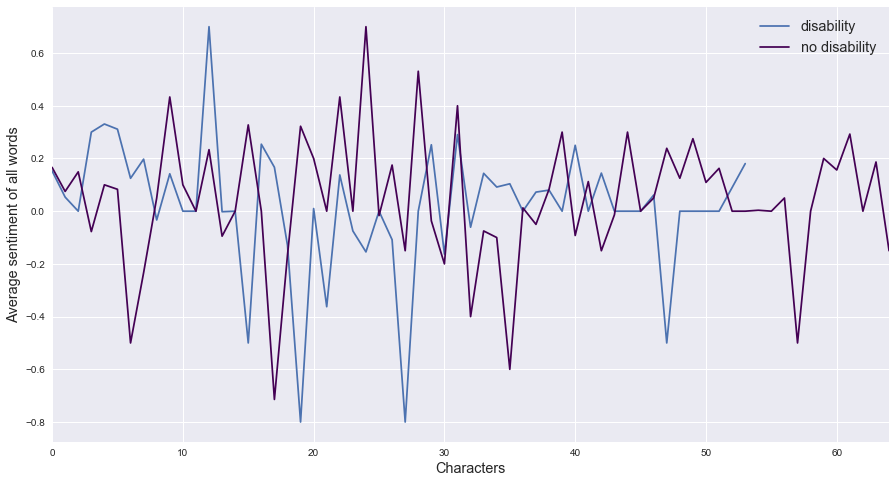

In [138]:
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0) # changing the default plot size to be bigger to facilitate reading

dis_obj_df = pd.DataFrame(dis_obj)
# dis_obj_df.head()

dis_sent_df = pd.DataFrame(dis_sent_only)
# dis_sent_df.head()

nodis_obj_df = pd.DataFrame(nodis_obj)
# mov_obj_df.head()

nodis_sent_df = pd.DataFrame(nodis_sent_only)
# mov_sent_df.head()

mylabels = ['disability', 'no disability']
a = dis_sent_df.plot()
nodis_sent_df.plot(ax=a, colormap='viridis')
print('Sentiment distributions compared:')
plt.legend(mylabels, loc='best', fontsize='x-large')
plt.ylabel('Average sentiment of all words', fontsize='x-large')
plt.xlabel('Characters', fontsize='x-large')
plt.savefig('sent_analysis.pdf', format='pdf', dpi=1000) # saving this figure as a high-quality graphic
plt.show()

This really helps us interpret our averages for sentiment much more clearly. We see that characters without disabilities have values that group around 0.2 value, with a smaller portion above and below. Meanwhile, the characters without disabilities have more varied distribution, which results in an average sentiment closer to neutral, which affects the objectivity negatively. But, to confirm, let's take a look at the objectivity plot:

Objectivity of sentiment distributions compared:


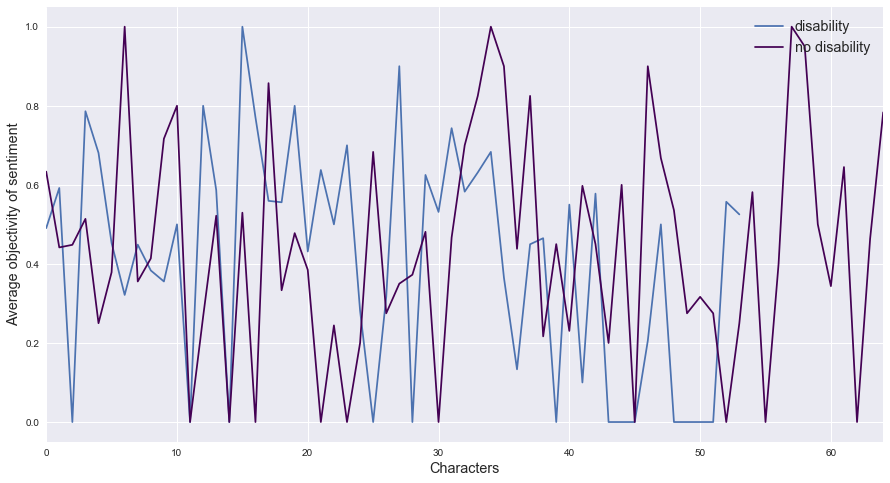

In [139]:
c = dis_obj_df.plot()
nodis_obj_df.plot(ax=c, colormap='viridis')
print('Objectivity of sentiment distributions compared:')
plt.legend(mylabels, loc='upper right', fontsize='x-large')
plt.ylabel('Average objectivity of sentiment', fontsize='x-large')
plt.xlabel('Characters', fontsize='x-large')
plt.savefig('sent_analysis_obj.pdf', format='pdf', dpi=1000) # saving this figure as a high-quality graphic
plt.show()

This plot shows how wildly objectivity jumps based on how polar the sentiments are for each character.

All-in-all our sentiment analysis mostly confirms assumptions that most researchers in disability studies would have made about depictions of characters with disabilities in fiction: that they'd mostly be more negative than characters without disabilities. But this is by a huge margin--about 2.5 times more negative. However, given that our corpus is relatively biased toward leading or at least strong supporting characters with disabilities, this is slightly surprising. I'm still wary of potential quirks here with this data since the disparity is so high, but it could be that the problem with character depictions is just much greater than expected.

### Future Work
This project has been fascinating for me, and a great learning experience. Now that I'm more familiar with the character data, it'd be very interesting to explore the best classifier to use for this type of data and then optimize this code to run at scale on all the characters. I think there would be some very interesting developments with regard to both compiling a corpus of characters in fiction that have disabilities that could be shared for study, as well as possibly uncovering characters who might have disabilities that were spoken about in coded, more discrete terms--something that has not been atypical for people with disabilities in real life and in media throughout all of history.

The other potential extra facet to include is time. I'd be fascinated to see if and how sentiment and top associated words change over time for characters with disabilities. I think the layman thought would be that we are getting more accepting of individuals with disabilities, and thus our words for these characters might more resemble those of other characters, which could make classification even harder and impact sentiment. That would be another logical next step to this proof-of-concept.

### Acknowledgements
This project has been hugely aided by Dr. Ted Underwood, the course instructor and author of many pieces of code here ranging from seeds upon which I built to some of the finished functions I employed. Dr. Underwood also graciously helped me scope and trouble shoot this project and also made available data that is still fairly new and pretty unused. I'm very grateful for his time and efforts on all of these.

Dr. Peter Organisciak, my instructor for another course this semester, LIS 590TXL Text Mining, has also been quite helpful in increasing my awareness of other modules and libraries available for this type of work, as well as general text analysis troubleshooting.

Also thank you to Dr. Underwood and Dr. Bamman who extracted this amazing character data I used and to HathiTrust who first made this data available for them to do so.